# Create a wetland type map

### Background
This notebook can be used to generate wetland type map over a region defined by a vector.


In [1]:
%matplotlib inline

import os
import re
import json
import time
import random
import rasterio
import datacube
import warnings
import subprocess
import numpy as np
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
from joblib import load
from odc.algo import xr_geomedian
from odc.dscache.tools import tiling
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap,BoundaryNorm
from datacube.utils import geometry
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from datacube.utils.geometry import BoundingBox, Geometry
from deafrica_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
from deafrica_tools.classification import predict_xr
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, display_map


## Create Dask cluster for running predictions
We use dask to parallel and speed up processing

In [2]:
# Set up a dask cluster
create_local_dask_cluster()

2023-10-16 09:59:37,177 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-o0qwal8o', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37957,Workers: 1
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:37423,Total threads: 4
Dashboard: /user/mpho.sadiki@digitalearthafrica.org/proxy/34589/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:33471,


## Load the model 
We use the model trained and saved in the [Train_Classification_Algorithm](04_Train_Classification_Algorithm.ipynb).

### Load area of interest (AOI)

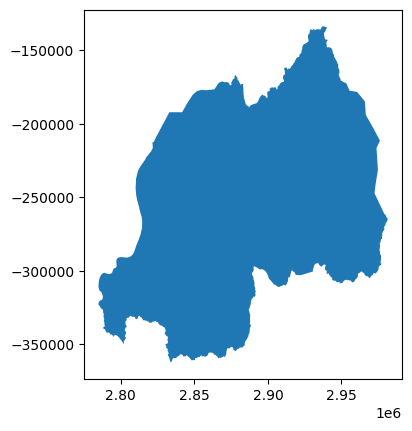

In [3]:
prefix = 'Rwanda'  # Specify the desired prefix - name of area of interest (aoi) is best to ensure the files have the aoi prefix when saved

aoi_boundaries_gdf = admin_boundaries_gdf = gpd.read_file("data/rwanda.geojson").to_crs("EPSG:6933")
aoi_boundaries_gdf.plot()
geom = Geometry(aoi_boundaries_gdf.geometry.iloc[0], crs=aoi_boundaries_gdf.crs)
geom_gdf = gpd.GeoDataFrame(geometry=[geom], crs=geom.crs)


In [4]:
# load trained classifier
rf_model_path=f'results/{prefix}_RF_model.joblib'

model = load(rf_model_path).set_params(n_jobs=1)
print('loaded random forest model:\n',model)

loaded random forest model:
 RandomForestClassifier(max_features='log2', n_jobs=1, random_state=1)


### Break area of interest into tiles for smaller processing chunks

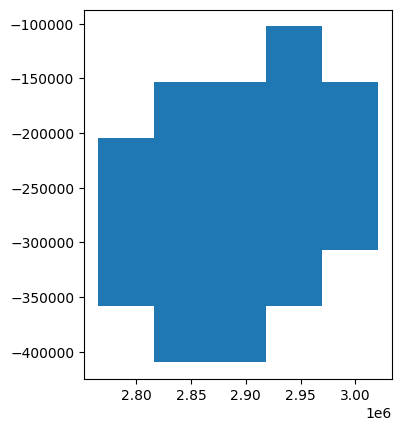

In [5]:
# Create a gridspec from string and convert to geoms
test = tiling.parse_gridspec(s="epsg:6933;50;1024")
test.tile_coords(tile_index=(0, 0))
tiles = test.tiles_from_geopolygon(geom)
geoms = (i[1].extent.geom for i in tiles)

geoms_df = gpd.GeoDataFrame(geometry=list(geoms))

# Set the CRS to EPSG:6933
geoms_df.crs = "EPSG:6933"

geoms_df.to_file(f"data/{prefix}_tiles.geojson", driver="GeoJSON")

# Plot the geometries
geoms_df.plot()

# Display the plot
plt.show()


## Create the query for running the predictions

We use the query saved from the feature extraction notebook to ensure data from the same periods are retrieved. However, only selected features will be used. 

> We add `dask_chunks` to the query parameter so the data will be lazy-loaded and only the features used by the model will be calculated.

In [6]:
time = ('2022')
# using nine spectral bands with 10~20 m spatial resolution
resolution = (-20,20)
output_crs='epsg:6933'

def feature_layers(query):
    # connect to the datacube
    dc = datacube.Datacube(app='feature_layers')
    
    # load s2 annual geomedian
    ds = dc.load(
        product='gm_s2_annual',
        measurements = ['blue','green','red','red_edge_1','red_edge_2', 'red_edge_3','nir_1','nir_2','swir_1','swir_2','emad','smad','bcmad'],
        **query)
    
    # calculate some band indices
    ds = calculate_indices(ds,
                           index=['NDVI', 'MNDWI','TCW'],
                           drop=False,
                           satellite_mission='s2')
    
    
    # Add a prefix "Annual" to the band names
    new_band_names = ['Annual_' + band_name for band_name in ds.data_vars]
    ds = ds.rename({old_band_name: new_band_name for old_band_name, new_band_name in zip(ds.data_vars, new_band_names)})

    # stack multi-temporal measurements and rename them
    n_time = ds.dims['time']
    list_measurements = list(ds.keys())
    list_stack_measures = []
    for j in range(len(list_measurements)):
        for k in range(n_time):
            variable_name = list_measurements[j]+'_'+str(k)
            measure_single = ds[list_measurements[j]].isel(time=k).rename(variable_name)
            list_stack_measures.append(measure_single)
    ds_stacked = xr.merge(list_stack_measures, compat='override')

    
    # Load the Sentinel-1 data    
    ds_s1 = dc.load(product=["s1_rtc"],
                  measurements=['vv', 'vh'],
                  group_by="solar_day",
                  **query
                 )
    # Add a prefix "Sent1_" to the variables in ds_s1
    ds_s1 = ds_s1.rename({old_var: 'sent1_' + old_var for old_var in ds_s1.data_vars})

    # median values are used to scale the measurements so they have a similar range for visualization
    med_s1 = ds_s1[['sent1_vv','sent1_vh']].median(dim='time')
    
    # Add ALOS L-Band Annual mosaic
    ds_alos = dc.load(product='alos_palsar_mosaic',
                      measurements=['hh','hv'],
                      **query)
    
    # Add a prefix "Sent1_" to the variables in ds_s1
    ds_alos = ds_alos.rename({old_var: 'alos_' + old_var for old_var in ds_alos.data_vars})
        
    med_alos = ds_alos[['alos_hh','alos_hv']].median(dim='time')
    

    # Add WOfS Annual summary
    wofs_annual = dc.load(product='wofs_ls_summary_annual',
               like=ds.geobox,
               time=query['time'])
    wofs_annual_frequency = wofs_annual.frequency
    wofs_annual_frequency.name = 'WOfS_annual_frequency'
    
    
    # loop through the terrain attribite files and add them to the dataset
    folder = os.path.join("data/terrain_attributes/", prefix)
    for filename in os.listdir(folder):
            if filename.endswith('.tif'):
                filepath = os.path.join(folder, filename)
                tif = rio_slurp_xarray(filepath, gbox=ds.geobox)
                tif = tif.to_dataset(name=filename.replace('.tif', ''))
                ds_stacked = xr.merge([ds_stacked, tif], compat='override')


    # merge all the datasets into a single dataset
    ds_stacked = xr.merge([ds_stacked, med_s1, med_alos, wofs_annual_frequency], compat='override')

    return ds_stacked

## Apply classification model to predict wetlands in the AOI

The model will be applied over each tile, producing a prediction map and a probabilities map. The maps are saved as Cloud-Optimized Geotiffs (COGs).

> Tiles are processed in sequence. For each tile, the processing needs to fit into the compute resources available in the sandbox. Make the tile size smaller if you run out of memory. For production of a map over a large region or country, consider applying for [a large sandbox (with more CPUs and momery)](
https://helpdesk.digitalearthafrica.org/portal/en/community/topic/call-for-application-for-access-to-large-sandboxes-15-processing-cores-and-120-gb-of-memory)

If output files for a tile already exist, processing for the tile can be skipped. This is useful if the process fails partway through, or if you are logged out of the sandbox before all tiles are completed.

In [7]:
skip_exisiting = False

skip_existing = False
output_folder = "results"
tiles_pred_folder = os.path.join(output_folder, "tiles_pred")
os.makedirs(tiles_pred_folder, exist_ok=True)

In [8]:
predictions = []
dask_chunks = {'x':2500,'y':2500}

# generate a datacube query object
query = {
    'geopolygon': geom,
    'time': time,
    'resolution': resolution,
    'output_crs': output_crs,
    'dask_chunks': dask_chunks,
}

for index in range(len(geoms_df)):   # Iterate over the tiles
    aoi = geoms_df.iloc[index]
#     print(f"Processing Polygon {index + 1} of {len(geoms_df)}")
    progress_text = f"Processing Polygon {index + 1} of {len(geoms_df)}"
    print(progress_text, end="\r")  #

    # Check if polygon has already been processed. If so, skip
    output_filename = os.path.join(
        tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_prediction.tif")
    probabilities_filename = os.path.join(
        tiles_pred_folder, f"{prefix}_tile{index:03d}_wetland_probabilities.tif")
    if skip_existing and os.path.exists(output_filename) and os.path.exists(probabilities_filename):
        print("Completed; Skipping")
        continue

    # set up query based on aoi geometry
    geom = geometry.Geometry(geom=aoi.geometry, crs=geoms_df.crs)
    query.update({"geopolygon": geom})
    
    # calculate features
    data = feature_layers(query).persist()

    # Convert xarray Dataset object to Dask array
    data_dask = data.chunk(dask_chunks)

    # predict using the imported model
    predicted = predict_xr(model,
                           data_dask,
                           proba=True,
                           persist=True,
                           clean=True,
                           return_input=True
                           ).compute().persist()
    
    # Create a mask for the aoi
    print("    Getting AOI mask")
    aoi_mask = xr_rasterize(
        gdf=gpd.GeoDataFrame({"Polygon": [index], "geometry": [
                             aoi.geometry]}, crs=geoms_df.crs),
        da=predicted,
        crs=output_crs,
    )

    # set the no data value
    NODATA = 255

    # Mask the predictions
    print("    Preparing predictions")
    predicted_masked = (
        predicted.Predictions.where(aoi_mask == 1, NODATA)
    )
    predicted_masked.attrs["nodata"] = NODATA

    # Write predictions to COG
    print(f"    Writing predictions to {output_filename}")
    write_cog(
        predicted_masked,
        fname=output_filename,
        overwrite=True,
        nodata=255,
    )

    del predicted_masked

    # Mask the probabilities
    probability_masked = (
        predicted.Probabilities.where(aoi_mask == 1, NODATA)
    )
    probability_masked.attrs["nodata"] = NODATA

    print(f"    Writing probabilities to {probabilities_filename}")
    write_cog(
        probability_masked,
        fname=probabilities_filename,
        overwrite=True,
        nodata=255,
    )

    del probability_masked

    del aoi_mask
    
    print("\n", end='')
    
    

predicting...lygon 1 of 21


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


   probabilities...
   input features...
    Getting AOI mask
    Preparing predictions
    Writing predictions to results/tiles_pred/Rwanda_tile000_wetland_prediction.tif
    Writing probabilities to results/tiles_pred/Rwanda_tile000_wetland_probabilities.tif

predicting...lygon 2 of 21
   probabilities...
   input features...
    Getting AOI mask
    Preparing predictions
    Writing predictions to results/tiles_pred/Rwanda_tile001_wetland_prediction.tif
    Writing probabilities to results/tiles_pred/Rwanda_tile001_wetland_probabilities.tif

predicting...lygon 3 of 21
   probabilities...
   input features...
    Getting AOI mask
    Preparing predictions
    Writing predictions to results/tiles_pred/Rwanda_tile002_wetland_prediction.tif
    Writing probabilities to results/tiles_pred/Rwanda_tile002_wetland_probabilities.tif

predicting...lygon 4 of 21
   probabilities...
   input features...
    Getting AOI mask
    Preparing predictions
    Writing predictions to results/tiles_pred

## Merge the tiles and export the final wetland predicitons and probabilities 

In [9]:
skip_existing = False

# Get the list of files in the tiles_pred folder
tile_files = os.listdir(tiles_pred_folder)

# Create a list to store the paths of prediction and probability files
prediction_files = []
probability_files = []

# Define the pattern for matching the filenames
pattern_prediction = fr"{prefix}_tile\d+_wetland_prediction.tif"
pattern_probability = fr"{prefix}_tile\d+_wetland_probabilities.tif"

# Compile the regular expression patterns
regex_prediction = re.compile(pattern_prediction)
regex_probability = re.compile(pattern_probability)

# Iterate over the tile files
for file in tile_files:
    # Check if the file is a prediction file
    if regex_prediction.match(file):
        prediction_files.append(os.path.join(tiles_pred_folder, file))
    # Check if the file is a probability file
    elif regex_probability.match(file):
        probability_files.append(os.path.join(tiles_pred_folder, file))

# Define the output mosaic filenames
out_mosaic_prediction = f"{output_folder}/{prefix}_merged_wetland_prediction.tif"
out_mosaic_probabilities = f"{output_folder}/{prefix}_merged_wetland_probabilities.tif"

# Remove the merged files if they already exist
if os.path.exists(out_mosaic_prediction):
    subprocess.run(f"rm {out_mosaic_prediction}", shell=True)

if os.path.exists(out_mosaic_probabilities):
    subprocess.run(f"rm {out_mosaic_probabilities}", shell=True)

# Merge the individual tiles into the merged files
merge_cmd_prediction = f"gdal_merge.py -o {out_mosaic_prediction} -co COMPRESS=Deflate -ot Byte {' '.join(prediction_files)} -init 255 -a_nodata 255"
subprocess.run(merge_cmd_prediction, shell=True)

merge_cmd_probabilities = f"gdal_merge.py -o {out_mosaic_probabilities} -co COMPRESS=Deflate -ot Byte {' '.join(probability_files)} -init 255 -a_nodata 255"
subprocess.run(merge_cmd_probabilities, shell=True)

# Load the merged predictions as xarray DataArray
merged_prediction = rxr.open_rasterio(out_mosaic_prediction).squeeze()
merged_probabilities = rxr.open_rasterio(out_mosaic_probabilities).squeeze()

# Rasterize the area of interest polygon
aoi_raster = xr_rasterize(gdf=geom_gdf,
                          da=merged_prediction,
                          crs=merged_prediction.rio.crs)

# Mask the wetland classes pixels within the AOI
wetland_predictions = merged_prediction.where((merged_prediction != 0) &
                                              (aoi_raster != 0))

# Define the output clipped filenames
clipped_prediction_file = f"{output_folder}/{prefix}_final_wetland_prediction.tif"
clipped_probabilities_file = f"{output_folder}/{prefix}_final_wetland_probabilities.tif"

# Write the clipped wetland predictions to file
write_cog(
    wetland_predictions,
    fname=clipped_prediction_file,
    overwrite=True,
    nodata=255,
)

# Clip the wetland probabilities to the AOI
wetland_probabilities = merged_probabilities.where((merged_prediction != 0) &
                                                   (aoi_raster != 0))

# Write the clipped wetland probabilities to file
write_cog(
    wetland_probabilities,
    fname=clipped_probabilities_file,
    overwrite=True,
    nodata=255,
)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


PosixPath('results/Rwanda_final_wetland_probabilities.tif')

### Plot the wetland predicition and probabilities

/tmp/ipykernel_3022/3510208163.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


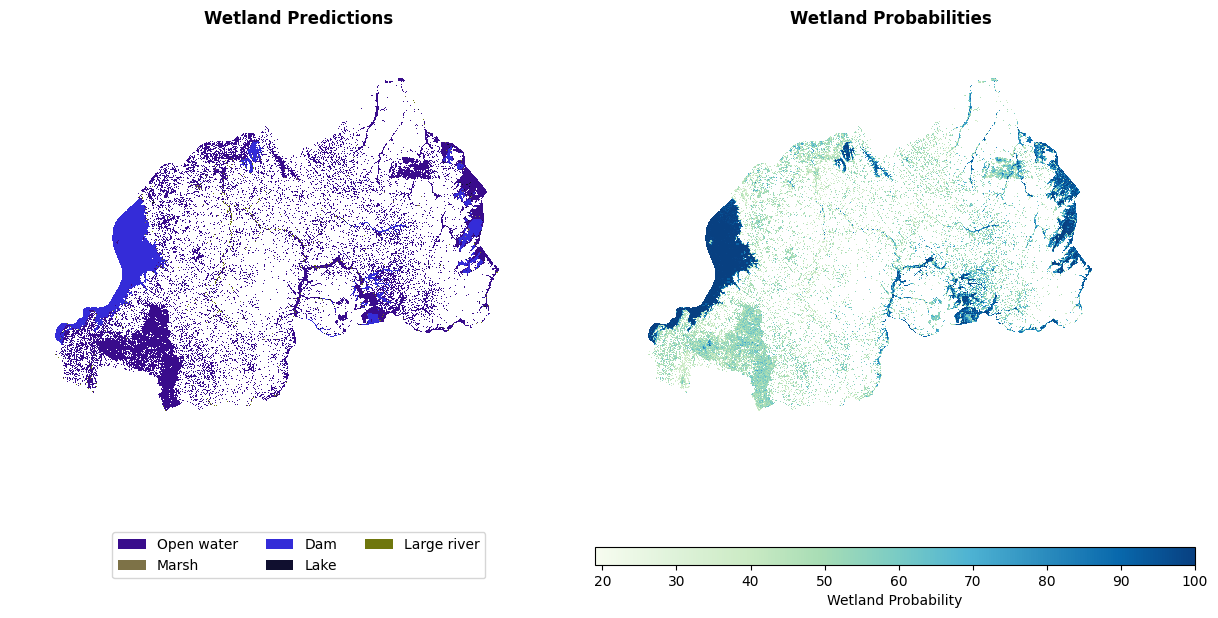

In [10]:
# Import the class label dictionary
with open(f'{prefix}_labels_dict.json', 'r') as json_file:
    labels_dict = json.load(json_file)

# Generate random colors for each class (excluding class 0)
random.seed(42)  # Set a seed for reproducibility
class_colors = {class_name: f'#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}'
                for class_name in labels_dict if labels_dict[class_name] != 0}

# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot wetland predictions
cmap = ListedColormap([class_colors[class_name] for class_name in labels_dict if labels_dict[class_name] != 0]) # exclude non-wetland 
wetland_predictions.plot.imshow(ax=axes[0],
                                cmap=cmap,
                                add_colorbar=False,
                                interpolation='none')
axes[0].set_title('Wetland Predictions', fontweight = 'bold')
axes[0].set_axis_off()

# Plot clipped wetland probabilities
im = wetland_probabilities.plot.imshow(ax=axes[1],
                                       cmap='GnBu',
                                       add_colorbar=False)
axes[1].set_title('Wetland Probabilities', fontweight = 'bold')
axes[1].set_axis_off()

# Add colorbar for wetland probabilities
cax = fig.add_axes([0.50, 0.05, 0.5, 0.03])  # Define the position of the colorbar
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Wetland Probability')

# Add legend
patches_list = [Patch(facecolor=class_colors[class_name]) for class_name in labels_dict if labels_dict[class_name] != 0]
legend = axes[0].legend(patches_list, [class_name for class_name in labels_dict if labels_dict[class_name] != 0],
                       loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.1))

# Adjust spacing
fig.tight_layout()

# Show the plot
plt.show()


### Post classification testing

In [11]:
# Load the testing points GeoDataFrame
testing_points = gpd.read_file(f'data/{prefix}_testing_samples.geojson')

# Open the raster file using rasterio
with rasterio.open(f"results/{prefix}_merged_wetland_prediction.tif") as src:
    # Read the raster values as a numpy array
    raster_values = src.read()

    # Get the affine transformation matrix to convert pixel coordinates to map coordinates
    transform = src.transform

    # Create an empty list to store the sampled values
    sampled_values = []

    # Iterate over the points in the GeoDataFrame
    for point in testing_points.geometry:
        # Convert the point coordinates to pixel coordinates
        row, col = rasterio.transform.rowcol(transform, point.x, point.y)

        # Sample the raster values at the corresponding pixel coordinates
        values = raster_values[:, row, col]  # If there are multiple bands in the raster

        # Append the sampled values to the list
        sampled_values.append(values)

    # Add the sampled values as a new column in the GeoDataFrame
    testing_points["sampled_values"] = sampled_values
    
    
testing_points["sampled_values"] = testing_points["sampled_values"].astype(int)

# Calculate the number of correctly classified samples
correct_count = len(testing_points[testing_points["sampled_values"] == testing_points["class_id"]])

# Calculate the total number of samples
total_count = len(testing_points)

# Calculate the accuracy as a percentage
accuracy_percentage = (correct_count / total_count) * 100

# Print the accuracy percentage
print(f"Overall Accuracy: {accuracy_percentage:.2f}%")    


Overall Accuracy: 81.21%


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-10-16'